In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from __future__ import annotations
import plotly.express as px


In [43]:
df = pd.read_excel('Datos/Aldebaran_pepsi.xlsx', sheet_name='Aldebaran_pepsi')
df.to_csv('Datos/Aldebaran_pepsi.csv', index=False)
iron = pd.read_excel('Datos/Nave_table_2.xlsx', sheet_name='A', usecols="F")
iron.to_csv('Datos/Nave.csv', index=False)

In [62]:
# Devuelve los índices i que cumplen con la condicion discreta de mínimo local: y[i-1] > y[i] < y[i+1]
def detect_discrete_minima_candidates(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y)
    if y.size < 3:
        return np.array([], dtype=int)
    cond = (y[1:-1] < y[0:-2]) & (y[1:-1] < y[2:])
    return np.nonzero(cond)[0] + 1


# Ajusta un polinomio de grado 'degree' a los puntos (x_win, y_win) y refina la posición del mínimo local alrededor del punto x_center (candidato discreto). 
# Da información de la curvatura y si el mínimo es válido.
def _fit_poly_and_refine_min(x_win, y_win, degree, x_center):
    # Centrar x para mejorar la condición numérica
    x_shift = x_win - x_center
    coeffs = np.polyfit(x_shift, y_win, deg=degree)
    p = np.poly1d(coeffs)

    dp = p.deriv(1)
    d2p = p.deriv(2)
    d3p = p.deriv(3)

    # Raíces de la primera derivada (en el sistema centrado)
    roots = np.roots(dp)
    roots = roots[np.isclose(roots.imag, 0, atol=1e-12)].real

    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Limitar raíces al rango de la ventana centrada
    x_min, x_max = x_shift.min(), x_shift.max()
    roots = roots[(roots >= x_min) & (roots <= x_max)]
    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Elegir la raíz más cercana al candidato (en coordenadas centradas)
    root_shift = roots[np.argmin(np.abs(roots - 0))]  # 0 porque centramos en x_center
    x_star = x_center + root_shift  # volver a coordenadas originales
    y_star = p(root_shift)

    curvature = d2p(root_shift)   # segunda derivada
    slope_asym = d3p(root_shift)  # tercera derivada
    is_min = curvature > 0

    return float(x_star), float(y_star), True, bool(is_min), float(curvature), float(slope_asym)



# Encuentra mínimos locales en los datos (x, y) ajustando polinomios en ventanas alrededor de los candidatos discretos.
def find_local_minima_polyfit(
    x: np.ndarray,
    y: np.ndarray,
    window_pts: int = 15,
    degree: int = 4,
    min_points: int = None,
    min_curvature: float = 10,
    max_slope_asym: float = 70,
) -> pd.DataFrame:

    if window_pts < degree + 1:
        raise ValueError("window_pts debe ser al menos degree+1.")
    if min_points is None:
        min_points = degree + 1
    if min_points < degree + 1:
        raise ValueError("min_points debe ser >= degree+1.")

    n = len(x)
    half = window_pts // 2
    candidates = detect_discrete_minima_candidates(y)
    rows = []

    for i in candidates:
        start = max(0, i - half)
        end = min(n, start + window_pts)
        start = max(0, end - window_pts)

        x_win = x[start:end]
        y_win = y[start:end]

        if x_win.size < min_points:
            rows.append({
                "idx_candidate": int(i),
                "x_refined": np.nan,
                "y_refined": np.nan,
                "curvature": np.nan,
                "slope_asym": np.nan,
                "valid_minimum": False,
            })
            continue

        try:
            x_star, y_star, root_in_window, is_min, curvature, slope_asym = _fit_poly_and_refine_min(
                x_win, y_win, degree, x_center=x[i]
            )
        except np.linalg.LinAlgError:
            x_star, y_star, root_in_window, is_min, curvature, slope_asym = np.nan, np.nan, False, False, np.nan

        # Aplicar filtro de curvatura y de tercera derivada
        valid = bool(is_min and 
                     curvature >= min_curvature and 
                     abs(slope_asym) < max_slope_asym)

        rows.append({
            "idx_candidate": int(i),
            "x_refined": x_star,
            "y_refined": y_star,
            "curvature": curvature,
            "slope_asym": slope_asym,
            "valid_minimum": valid,
        })

    return pd.DataFrame(rows)


In [63]:
df = pd.read_csv('Datos/Aldebaran_pepsi.csv')


x = df.iloc[:,0]  # primera columna
y = df.iloc[:,1]  # segunda columna


df_min = find_local_minima_polyfit(x, y, window_pts=15, degree=4)
df_min = df_min[df_min["valid_minimum"]]
df_min = df_min[df_min["x_refined"] > 0]


 
print(df_min)


       idx_candidate    x_refined  y_refined   curvature  slope_asym  \
11               223  3951.961788   0.451508  213.389744   64.264660   
35               649  3955.625477   0.834652   16.163200    0.575262   
39               732  3956.342186   0.079364   13.260553   63.194854   
41               772  3956.680615   0.195455  121.012587   11.995732   
51               954  3958.214743   0.083081   14.660365   -8.586411   
...              ...          ...        ...         ...         ...   
20759         418815  9133.419049   0.255105  118.584638  -27.594162   
20762         418866  9134.306377   0.674731   57.784784    2.763456   
20763         418883  9134.599192   0.864459   13.208487    2.299942   
20765         418914  9135.133880   0.052467   80.313591  -56.733094   
20768         419008  9136.757796   0.785749   16.518485   49.411146   

       valid_minimum  
11              True  
35              True  
39              True  
41              True  
51              True

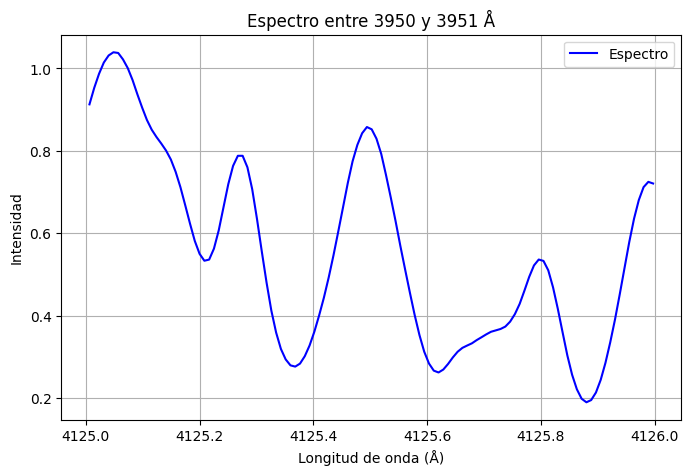

In [64]:
## Hacer un gráfico del espectro entre dos valores específicos de longitud de onda

x1 = 4125
x2 = 4126

mask = (x >= x1) & (x <= x2)
x_range = x[mask]
y_range = y[mask]

# Graficar
plt.figure(figsize=(8, 5))
plt.plot(x_range, y_range, label="Espectro", color="blue")

plt.xlabel("Longitud de onda (Å)")
plt.ylabel("Intensidad")
plt.title("Espectro entre 3950 y 3951 Å")
plt.legend()
plt.grid(True)
plt.show()

In [65]:
# Tolerancia
tol = 0.05

# Crear lista para almacenar matches
matches = []

for i, theo in enumerate(iron.iloc[:,0]):  # recorremos las líneas teóricas
    # Filtrar mínimos observados que estén cerca de la línea teórica
    nearby = df_min[(df_min["x_refined"].notna()) & 
                    (abs(df_min["x_refined"] - theo) <= tol)]
    
    for _, obs in nearby.iterrows():
        matches.append({
            "lambda_theo": theo,                 # línea teórica (Fe I/II)
            "lambda_obs": obs["x_refined"],      # longitud observada en el espectro
            "y_obs": obs["y_refined"],           # intensidad observada
            "delta": obs["x_refined"] - theo     # diferencia entre observado y teórico
        })

# Pasar a dataframe
df_matches = pd.DataFrame(matches)

print(df_matches)


     lambda_theo   lambda_obs     y_obs     delta
0      3971.3227  3971.325440  0.203297  0.002740
1      4085.3031  4085.289467  0.113711 -0.013633
2      4098.1758  4098.171061  0.116510 -0.004739
3      4109.8017  4109.764376  0.059800 -0.037324
4      4125.8804  4125.881585  0.189582  0.001185
..           ...          ...       ...       ...
270    9103.6375  9103.626160  0.728207 -0.011340
271    9117.1327  9117.140957  0.066899  0.008257
272    9118.8816  9118.883521  0.351210  0.001921
273    9136.7397  9136.757796  0.785749  0.018096
274    9136.7931  9136.757796  0.785749 -0.035304

[275 rows x 4 columns]


In [66]:
c = 299792.458

df_matches["velocity_kms"] = c * (df_matches["delta"]) / df_matches["lambda_theo"]

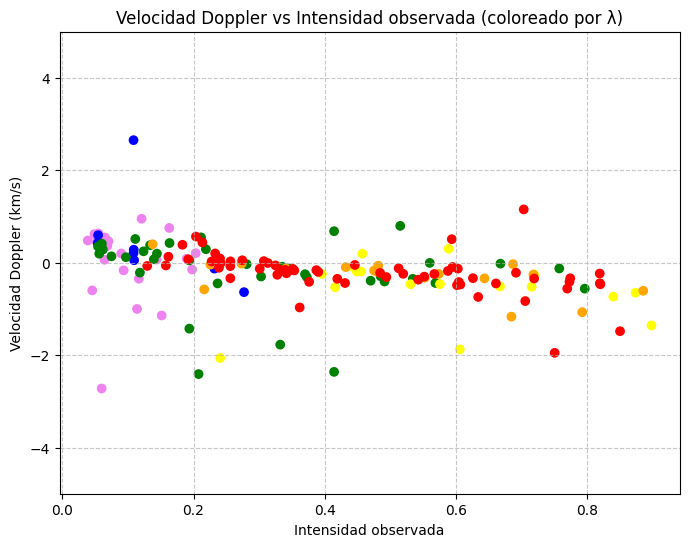

In [ ]:
def wavelength_to_color(wl):
    if 3800 <= wl < 4500:
        return "violet"
    elif 4500 <= wl < 4950:
        return "blue"
    elif 4950 <= wl < 5700:
        return "green"
    elif 5700 <= wl < 5900:
        return "yellow"
    elif 5900 <= wl < 6200:
        return "orange"
    elif 6200 <= wl <= 7500:
        return "red"
    else:
        return "gray"  # fuera del rango visible

# Crear columna de colores
df_matches["Color"] = df_matches["lambda_obs"].apply(wavelength_to_color)

# Gráfico en Matplotlib
# Filtrar para eliminar los puntos grises
df_visible = df_matches[df_matches["Color"] != "gray"]

# Gráfico en Matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(
    df_visible["y_obs"], 
    df_visible["velocity_kms"], 
    c=df_visible["Color"]
)

plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (km/s)")
plt.ylim(-5, 5)
plt.title("Velocidad Doppler vs Intensidad observada (coloreado por λ)")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()
